<a href="https://colab.research.google.com/github/leedy40259/Ybigta_summer/blob/main/0806_wordcloud_konlpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 데이콘 영화리뷰 감성분석 경진대회 </h1>

어렵지 않으니 스스로 # To do 부분을 채워보시고 고민해봐도 모르겠다면 코드공유를 참고해주세요! 아니면 과제를 다 하시고 설명이 자세히 적혀있는 코드공유로 리뷰를 하셔도 좋습니다

# train.csv 학습/검증

### 필요한 패키지 불러오기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings(action='ignore')
import nltk
# nltk.download('all') # 처음 실행 시 주석을 제거하고 실행해주세요!

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### train 데이터 불러오기

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Ybigta_summer/KoNLPy/train (1).csv') # train 데이터 불러오기
data # 데이터 확인하기: 긍정인지 부정인지 label이 되어 있음

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [ ]:
data.isna().sum() # 결측치 확인

id          0
document    0
label       0
dtype: int64

### 학습/검증셋 분리하기

모델링 후 성능을 검증하기 위해 학습셋과 검증셋으로 train 데이터를 나눠줍니다.

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data)
train.reset_index(inplace=True) # 전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화해주었습니다.
val.reset_index(inplace=True)

In [ ]:
train # train 셋 확인

,index,id,document,label
0,4186,4187,지금까지 만나본 최고 드라마...,1
1,2188,2189,노출을 하려면 제대로 하던가... 모자이크를 하던가.. 보는 내가 '민망해',0
2,2963,2964,엘렌 페이지에 빠진다 화목한 주노네,1
3,1528,1529,별 없는건할수없나 1점도아까움,0
4,4971,4972,사투리 아줌마! 대박 ㅎㅎㅎ 재밌당 은나아~~,1
...,...,...,...,...
3745,4224,4225,우리나라의 세븐데이즈랑 비슷할것같은데 재밌겠다ㅎ,1
3746,3001,3002,"이걸 만든 자원과 자본, 시간, 인력, 기술에게 미안해지는 영화..",0
3747,1033,1034,"컨트리송,미국민요,CCM, 명배우연기와 함께 잔잔한 감동을 주는 좋은 영화",1
3748,3279,3280,벌써30년이되어가는영화네요 그런데 아직도 제목만 들어도 가슴이 찡해요,1


### 데이터 정제하기


가장 먼저 한글과 공백만 남긴 뒤 preprocessed라는 컬럼으로 저장하겠습니다.

In [ ]:
train['preprocessed'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외(^)하고 모두 제거
train[:5] # 데이터 확인

,index,id,document,label,preprocessed
0,4186,4187,지금까지 만나본 최고 드라마...,1,지금까지 만나본 최고 드라마
1,2188,2189,노출을 하려면 제대로 하던가... 모자이크를 하던가.. 보는 내가 '민망해',0,노출을 하려면 제대로 하던가 모자이크를 하던가 보는 내가 민망해
2,2963,2964,엘렌 페이지에 빠진다 화목한 주노네,1,엘렌 페이지에 빠진다 화목한 주노네
3,1528,1529,별 없는건할수없나 1점도아까움,0,별 없는건할수없나 점도아까움
4,4971,4972,사투리 아줌마! 대박 ㅎㅎㅎ 재밌당 은나아~~,1,사투리 아줌마 대박 ㅎㅎㅎ 재밌당 은나아


추가적으로 혹시 모를 다중공백도 제거해줍니다.

In [ ]:
train['preprocessed'] = train['preprocessed'].str.replace(" +", " ") # 다중 공백 제거
train[:5] # 데이터 확인

,index,id,document,label,preprocessed
0,4186,4187,지금까지 만나본 최고 드라마...,1,지금까지 만나본 최고 드라마
1,2188,2189,노출을 하려면 제대로 하던가... 모자이크를 하던가.. 보는 내가 '민망해',0,노출을 하려면 제대로 하던가 모자이크를 하던가 보는 내가 민망해
2,2963,2964,엘렌 페이지에 빠진다 화목한 주노네,1,엘렌 페이지에 빠진다 화목한 주노네
3,1528,1529,별 없는건할수없나 1점도아까움,0,별 없는건할수없나 점도아까움
4,4971,4972,사투리 아줌마! 대박 ㅎㅎㅎ 재밌당 은나아~~,1,사투리 아줌마 대박 ㅎㅎㅎ 재밌당 은나아


### 토큰화

#### 한국어에서의 토큰화

한국어는 영어와 달리 형태소(뜻을 가진 말의 최소 단위)간의 결합으로 어절이 이루어집니다. ex) 철수 -가 책 -을 읽- -었- -다

따라서 한국어 전용 형태소 분석기가 많이 존재하는데요, 이번에는 koNLPy라는 패키지의 Okt라는 형태소 분석기를 사용해보겠습니다.

이제 영화 리뷰 데이터에서 같은 방법으로 형태소 분석을 해볼까요?

In [ ]:
from konlpy.tag import Okt

okt = Okt()

In [ ]:
tokenized = [] # 데이터프레임의 한 컬럼으로 추가할 리스트
for sentence in train['preprocessed']: # 전처리된 리뷰들을 하나씩 꺼내옵니다
    # To do
    tokens = okt.morphs(sentence, stem = True)# 형태소 분석 (어간 추출로 옵션 설정)
    tokenize = " ".join(tokens) # tokens라는 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join시켜줍니다.
    tokenized.append(tokenize) # 형태소 단위로 띄어쓰기된 문자열을 최종 리스트에 추가해줍니다
train["tokenized_stem"] = pd.DataFrame(tokenized) # 리스트를 데이터프레임으로 변환해 tokenized_stem라는 컬럼명으로 추가해줍니다.

train.head() # 데이터 확인

,index,id,document,label,preprocessed,tokenized_stem
0,4186,4187,지금까지 만나본 최고 드라마...,1,지금까지 만나본 최고 드라마,지금 까지 만 나본 최고 드라마
1,2188,2189,노출을 하려면 제대로 하던가... 모자이크를 하던가.. 보는 내가 '민망해',0,노출을 하려면 제대로 하던가 모자이크를 하던가 보는 내가 민망해,노출 을 하다 제대로 하다 모자이크 를 하다 보다 내 가 민망하다
2,2963,2964,엘렌 페이지에 빠진다 화목한 주노네,1,엘렌 페이지에 빠진다 화목한 주노네,엘렌 페이지 에 빠지다 화목 한 주노 네
3,1528,1529,별 없는건할수없나 1점도아까움,0,별 없는건할수없나 점도아까움,별 없다 하다 없다 점도 아깝다 움
4,4971,4972,사투리 아줌마! 대박 ㅎㅎㅎ 재밌당 은나아~~,1,사투리 아줌마 대박 ㅎㅎㅎ 재밌당 은나아,사투리 아줌마 대박 ㅎㅎㅎ 재밌다 은 나아


형태소 분석 및 어간 추출을 완료한 "tokenized" 컬럼이 추가되었습니다!

### 품사 태깅(POS Tagging)

자 이제 다음 단계인 품사 태깅에 대해 알아봅시다.

품사 태깅이란 주어진 텍스트를 형태소 단위로 나눈 뒤, 각 형태소에 해당 품사를 태깅하여 리스트화 하는 것입니다.

한 예시를 살펴보니 Noun, Josa, Adverb, Adjective, Verb, Suffix, Punctuation, KoreanParticle 등으로 품사가 태깅되어 하나의 리스트 형태로 반환됩니다

태그되는 품사의 종류는 더 다양하니 직접 다양한 문장을 이용해 공부해보세요!

okt의 pos 함수만을 이용해 토큰화와 품사 태깅을 한번에 할 수 있습니다.

품사 태깅은 꼭 필요한 품사(ex. 명사)를 추출할 때 유용하게 쓰일 수 있겠네요.

바로 명사를 추출해볼까요?

In [ ]:
print(okt.nouns("오늘도 열심히 재밌는 코딩을 해볼까? 같이 힘내서 자연어 처리 고수들이 됩시다! ㅎㅎ"))

['오늘', '코딩', '자연어', '처리', '고수']


okt의 nouns 함수를 사용해 간편하게 명사만을 추출하였습니다!

이렇게 간단하게 명사만을 추출할수도 있지만, 영화 리뷰는 명사만으로 긍/부정을 판단하기 어렵기 때문에 

우선 임의로 명사, 동사, 형용사, 부사를 추출하여 사용해보겠습니다. (이 부분은 직접 고민하고 수정해보세요!)

In [ ]:
main_pos = [] # 데이터프레임의 새 컬럼이 될 리스트
for sentence in train['document']: # 리뷰들을 하나씩 가져옵니다
    # To do
    pos = okt.pos(sentence, stem=True)# 품사 태깅으로 형태소 분석을 진행하고 해당 리스트를 pos라는 변수로 받습니다
    main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ("Noun", "Adverb", "Adjective", "Verb")] # 가져오고자 하는 품사에 해당하면 해당 형태소를 main_words 리스트에 추가합니다.
    main_words_str = " ".join(main_words) # main_words 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join시켜줍니다.
    main_pos.append(main_words_str) # 선택한 형태소들로 이루어진 문자열을 최종 리스트에 추가해줍니다
train["main_pos"] = pd.DataFrame(main_pos) # 리스트를 데이터프레임으로 변환해 main_pos라는 컬럼명으로 추가해줍니다.

train.head() # 데이터 확인

,index,id,document,label,preprocessed,tokenized_stem,main_pos
0,4186,4187,지금까지 만나본 최고 드라마...,1,지금까지 만나본 최고 드라마,지금 까지 만 나본 최고 드라마,지금 나본 최고 드라마
1,2188,2189,노출을 하려면 제대로 하던가... 모자이크를 하던가.. 보는 내가 '민망해',0,노출을 하려면 제대로 하던가 모자이크를 하던가 보는 내가 민망해,노출 을 하다 제대로 하다 모자이크 를 하다 보다 내 가 민망하다,노출 하다 제대로 하다 모자이크 하다 보다 내 민망하다
2,2963,2964,엘렌 페이지에 빠진다 화목한 주노네,1,엘렌 페이지에 빠진다 화목한 주노네,엘렌 페이지 에 빠지다 화목 한 주노 네,엘렌 페이지 빠지다 화목 주노
3,1528,1529,별 없는건할수없나 1점도아까움,0,별 없는건할수없나 점도아까움,별 없다 하다 없다 점도 아깝다 움,별 없다 하다 없다 점도 아깝다 움
4,4971,4972,사투리 아줌마! 대박 ㅎㅎㅎ 재밌당 은나아~~,1,사투리 아줌마 대박 ㅎㅎㅎ 재밌당 은나아,사투리 아줌마 대박 ㅎㅎㅎ 재밌다 은 나아,사투리 아줌마 대박 재밌다 은 나아


자 이제 총 세 개의 전처리된 컬럼이 생성되었습니다!

어떤 전처리 과정이 성능이 가장 잘 나올지는 미지수입니다. 직접 다양한 시도를 통해 최적의 전처리 프로세스를 찾아보세요~

이번 베이스라인에서는 마지막에 생성한 main_pos 컬럼을 이용해 모델 학습을 진행하겠습니다.

### 벡터화

CountVectorizer를 사용하였습니다. 

In [ ]:
X_train = train.main_pos #training 데이터에서 문서 추출
y_train = train.label #training 데이터에서 라벨 추출

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# To do
vectorizer = CountVectorizer() #countvectorizer 생성
# countvectorizer 학습
X_train_vec = vectorizer.fit_transform(X_train) # transform

### 모델 학습

In [ ]:
from sklearn.linear_model import LogisticRegression #모델 불러오기
model = LogisticRegression() #객체에 모델 할당
model.fit(X_train_vec, y_train) #모델 학습

LogisticRegression()

### 검증셋으로 모델 성능 검증

먼저 검증 셋 val에 train 셋과 동일한 전처리 과정을 거쳐줍니다.

In [ ]:
# preprocessed
val['preprocessed'] = val['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
val['preprocessed'] = val['preprocessed'].str.replace(" +", " ") # 다중 공백 제거

# tokenized_stem
tokenized = []
for sentence in val['preprocessed']:
    # To do
    tokens = okt.morphs(sentence, stem = True)#형태소 분석 어간 추출 옵션
    tokenize = " ".join(tokens)
    tokenized.append(tokenize)
val["tokenized_stem"] = pd.DataFrame(tokenized)

# main_pos
main_pos = []
for sentence in val['document']:
    # To do
    pos = okt.pos(sentence, stem=True)# 품사 태깅 형태소 분석
    main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ("Noun", "Adverb", "Adjective", "Verb")] # 원하는 품사 선택
    main_words_str = " ".join(main_words)
    main_pos.append(main_words_str)
val["main_pos"] = pd.DataFrame(main_pos)

val

,index,id,document,label,preprocessed,tokenized_stem,main_pos
0,4848,4849,자살하지 말라고 이런 영화를 찍었다니,0,자살하지 말라고 이런 영화를 찍었다니,자살 하다 말 라고 이렇다 영화 를 찍다,자살 하다 말 이렇다 영화 찍다
1,3011,3012,왜 죽어야만 했을까..??ㅠㅠ너무 잔잔하면서 가혹한 영화,1,왜 죽어야만 했을까ㅠㅠ너무 잔잔하면서 가혹한 영화,왜 죽다 하다 ㅠㅠ 너무 잔잔하다 가혹하다 영화,왜 죽다 하다 너무 잔잔하다 가혹하다 영화
2,4716,4717,감독의 개성이 너무 좋다.......,1,감독의 개성이 너무 좋다,감독 의 개성 이 너무 좋다,감독 개성 너무 좋다
3,4964,4965,인디아나존스의 선배격 원작에 더 나은 유머와 유쾌함,1,인디아나존스의 선배격 원작에 더 나은 유머와 유쾌함,인디아나 존스 의 선 배격 원작 에 더 나은 유머 와 유쾌하다,인디아나 존스 선 배격 원작 더 나은 유머 유쾌하다
4,2692,2693,진짜 최악 이다! 본 시간이 아깝다.,0,진짜 최악 이다 본 시간이 아깝다,진짜 최악 이다 보다 시간 이 아깝다,진짜 최악 보다 시간 아깝다
...,...,...,...,...,...,...,...
1245,1952,1953,집에비됴까지있었지만 틀때마다 끝까지볼수없었다 재미없어서,0,집에비됴까지있었지만 틀때마다 끝까지볼수없었다 재미없어서,집 에 비됴 까지 있다 틀때 마다 끝 까지 보다 없다 재미없다,집 비됴 있다 틀때 끝 보다 없다 재미없다
1246,117,118,꼭 봐야하는 영화 마지막이 정말 소름끼치고 시민들의 하... 걍 닥치고 보자,1,꼭 봐야하는 영화 마지막이 정말 소름끼치고 시민들의 하 걍 닥치고 보자,꼭 보다 야하다 영화 마지막 이 정말 소름끼치다 시민 들 의 하 걍 닥치고 보다,꼭 보다 야하다 영화 마지막 정말 소름끼치다 시민 걍 닥치고 보다
1247,2142,2143,더봐야 알겠지만.. 이즈미 노아가 단발로 나온것 부터가 에러 ㅡㅡ;,0,더봐야 알겠지만 이즈미 노아가 단발로 나온것 부터가 에러 ㅡㅡ,더 보다 알다 이즈미 노아 가 단발 로 나오다 부터가 에러 ㅡㅡ,더 보다 알다 이즈미 노아 단발 나오다 에러
1248,933,934,유치하고 무난하면서 진부한 영화,0,유치하고 무난하면서 진부한 영화,유치하다 무난 하다 진부하다 영화,유치하다 무난 하다 진부하다 영화


학습한 모델로 예측할 X를 벡터화해줍니다.

In [ ]:
X_val = val.main_pos #validation 데이터에서 전처리된 문서 추출
y_val = val.label #validation 데이터에서 라벨 추출
# To do
X_val_vec = vectorizer.transform(X_val)# train셋으로 fit한 벡터라이저 이용해 transform

In [ ]:
from sklearn import *

#run model
y_pred = model.predict(X_val_vec)
print(y_pred)
#0:negative 1:positive


[0 1 1 ... 0 0 1]


In [ ]:
from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_val, y_pred)) # 정확도 확인

accuracy = 0.8408


train 셋으로 학습한 모델을 사용해 validation 셋을 예측해본 결과 0.8184의 정확도를 얻었습니다!

다양한 전처리 기법과 모델들을 사용하여 성능을 높여보세요~

# test.csv 분류하기

이제 본격적으로 대회에서 주어진 정답이 없는 test 데이터의 라벨을 예측해보겠습니다.

전처리 모델 학습 단계에서 test 데이터를 사용하면 data leakage로 간주되니

test.csv는 반드시 모델 학습이 끝난 뒤 예측시에만 등장해야 함에 주의해주세요!

train.csv를 이용한 전처리/학습을 test.cvs에 적용하는 것은 허용되지만, test.csv를 전처리/모델링에 직접적으로 이용하면 실격입니다.

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Ybigta_summer/KoNLPy/test.csv')
test

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다
...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..


동일한 전처리 과정을 거치되, data leakage가 발생하지 않도록 주의합니다.

In [ ]:
test.isna().sum()

id          0
document    0
dtype: int64

In [ ]:
# preprocessed
test['preprocessed'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
test['preprocessed'] = test['preprocessed'].str.replace(" +", " ") # 다중 공백 제거

# tokenized_stem
tokenized = []
for sentence in test['preprocessed']:
    # To do
    tokens = okt.morphs(sentence, stem = True)#형태소 분석, 어간 추출
    tokenize = " ".join(tokens)
    tokenized.append(tokenize)
test["tokenized_stem"] = pd.DataFrame(tokenized)

# main_pos
main_pos = []
for sentence in test['document']:
  # To do
    pos = okt.pos(sentence, stem=True)#품사 태그
    main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ("Noun", "Adverb", "Adjective", "Verb")] # 원하는 품사 추출
    main_words_str = " ".join(main_words)
    main_pos.append(main_words_str)
test["main_pos"] = pd.DataFrame(main_pos)

test.head()

,id,document,preprocessed,tokenized_stem,main_pos
0,1,시간 때우기 좋은 영화 지루함,시간 때우기 좋은 영화 지루함,시간 때우다 좋다 영화 지루함,시간 때우다 좋다 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱
2,3,Childhood fantasy,,,
3,4,멋있는 영화입니다. 잊을 수 없는!,멋있는 영화입니다 잊을 수 없는,멋있다 영화 이다 잊다 수 없다,멋있다 영화 이다 잊다 수 없다
4,5,너무 감동적이네요 펑펑 울었습니다,너무 감동적이네요 펑펑 울었습니다,너무 감동 적다 펑펑 울다,너무 감동 적다 펑펑 울다


In [ ]:
X_test = test.main_pos
# To do
X_test_vec = vectorizer.transform(X_test)# train셋으로 fit한 벡터라이저 이용해 transform
pred_test = model.predict(X_test_vec)
print(pred_test)

[0 1 0 ... 1 0 1]


# 워드클라우드

In [ ]:
test['pred']=pred_test

In [ ]:
test

,id,document,preprocessed,tokenized_stem,main_pos,pred
0,1,시간 때우기 좋은 영화 지루함,시간 때우기 좋은 영화 지루함,시간 때우다 좋다 영화 지루함,시간 때우다 좋다 영화 지루함,0
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,1
2,3,Childhood fantasy,,,,0
3,4,멋있는 영화입니다. 잊을 수 없는!,멋있는 영화입니다 잊을 수 없는,멋있다 영화 이다 잊다 수 없다,멋있다 영화 이다 잊다 수 없다,1
4,5,너무 감동적이네요 펑펑 울었습니다,너무 감동적이네요 펑펑 울었습니다,너무 감동 적다 펑펑 울다,너무 감동 적다 펑펑 울다,1
...,...,...,...,...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화,연 계 도 제대로 안되다 뭔가 부족하다 느낌 이 들다 찝찝하다 영화,계 제대로 안되다 뭔가 부족하다 느낌 들다 찝찝하다 영화,0
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....,내생에 최악의 영화중 하나 졸려서 미칠뻔,내생 에 최악 의 영화 중 하나 졸리다 미치다 뻔,내생 최악 영화 하나 졸리다 미치다 뻔,0
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!,지금까지 나온 드라마 중 최고였습니다 점 만점,지금 까지 나오다 드라마 중 최고 이다 점 만점,지금 나오다 드라마 중 최고 이다 점 만점,1
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..,영화값으로 엄청난 공연을 보았다 이게 웬 횡재,영화 값 으로 엄청나다 공연 을 보다 이 게 웬 횡재,영화 값 엄청나다 공연 보다 이 웬 횡재,0


In [ ]:
df=test.copy()

In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wordcloud 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import pandas as pd
import re

from wordcloud import WordCloud, STOPWORDS

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from collections import Counter

import matplotlib.font_manager as fm

fontpath = '/content/drive/MyDrive/Ybigta_summer/KoNLPy/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumGothic')
fm._rebuild()


In [96]:
pos = df[df['pred']==1] #긍정리뷰
neg = df[df['pred']==0] #부정리뷰

In [97]:
display(pos.head())
display(neg.head())

,id,document,preprocessed,tokenized_stem,main_pos,pred
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,훈훈하다 정이 느껴지다 영화 가족 끼리 드라마 보다 보다 딱,1
3,4,멋있는 영화입니다. 잊을 수 없는!,멋있는 영화입니다 잊을 수 없는,멋있다 영화 이다 잊다 수 없다,멋있다 영화 이다 잊다 수 없다,1
4,5,너무 감동적이네요 펑펑 울었습니다,너무 감동적이네요 펑펑 울었습니다,너무 감동 적다 펑펑 울다,너무 감동 적다 펑펑 울다,1
6,7,친구한테 추천받고 본 영화이지만 내가 남들한테 추천하는 영화,친구한테 추천받고 본 영화이지만 내가 남들한테 추천하는 영화,친구 한테 추천 받다 보다 영화 이지만 내 가 남 들 한테 추천 하다 영화,친구 추천 받다 보다 영화 내 남 추천 하다 영화,1
8,9,강배우 엄청난데... 여군버전으로 다시 안 찍나,강배우 엄청난데 여군버전으로 다시 안 찍나,강 배우 엄청나다 여군 버전 으로 다시 안 찍 나,강 배우 엄청나다 여군 버전 다시 안 찍,1


,id,document,preprocessed,tokenized_stem,main_pos,pred
0,1,시간 때우기 좋은 영화 지루함,시간 때우기 좋은 영화 지루함,시간 때우다 좋다 영화 지루함,시간 때우다 좋다 영화 지루함,0
2,3,Childhood fantasy,,,,0
5,6,어이 김구라 자세좀 똑바로 앉어방송마다 왜케 삐딱하게 앉는거지,어이 김구라 자세좀 똑바로 앉어방송마다 왜케 삐딱하게 앉는거지,어이 김구라 자세 좀 똑바로 앉다 방송 마다 왜케 삐 딱하다 앉다,어이 김구라 자세 좀 똑바로 앉다 방송 왜케 삐 딱하다 앉다,0
7,8,머 내용은 그닥... 특별하지않다,머 내용은 그닥 특별하지않다,머 내용 은 그닥 특별하다 않다,머 내용 그닥 특별하다 않다,0
9,10,이렇게 재밋게본 드라마 추노말거 없엇음 ㅜ짱,이렇게 재밋게본 드라마 추노말거 없엇음 ㅜ짱,이렇게 재밋게본 드라마 추다 없엇음 ㅜ 짱,이렇게 재밋게본 드라마 추다 없엇음 짱,0


## 긍정리뷰 워드클라우드

In [98]:
okt = Okt()

content_list = list(pos['main_pos'])
noun_list = []

for sentence in content_list:


    sentence = re.sub('[a-zA-z0-9]','', sentence)
    
    for word, tag in okt.pos(sentence):
      # 명사만 추출
        if tag in ['Noun']:  

            if len(word) == 1:
                continue

            else:
                noun_list.append(word)

count = Counter(noun_list)
poswords = dict(count.most_common(n=50)) 

In [99]:
poswords

{'가슴': 44,
 '가장': 30,
 '가족': 21,
 '감동': 150,
 '강추': 25,
 '계속': 21,
 '기억': 35,
 '눈물': 30,
 '느낌': 22,
 '다시': 90,
 '대박': 23,
 '드라마': 93,
 '리다': 33,
 '마음': 47,
 '마지막': 52,
 '매력': 47,
 '명작': 75,
 '모습': 22,
 '배우': 52,
 '보고': 81,
 '사람': 37,
 '사랑': 84,
 '생각': 91,
 '스토리': 37,
 '시리즈': 21,
 '아이': 22,
 '액션': 25,
 '여운': 35,
 '역시': 50,
 '연기': 93,
 '영상': 21,
 '영화': 836,
 '완전': 57,
 '음악': 32,
 '이야기': 28,
 '인간': 22,
 '인생': 42,
 '작품': 59,
 '장면': 36,
 '재미': 39,
 '정말': 216,
 '주인공': 21,
 '지금': 47,
 '진짜': 129,
 '처음': 27,
 '최고': 224,
 '추천': 34,
 '평점': 58,
 '하나': 35,
 '현실': 21}

In [100]:
poswords.items()

dict_items([('영화', 836), ('최고', 224), ('정말', 216), ('감동', 150), ('진짜', 129), ('드라마', 93), ('연기', 93), ('생각', 91), ('다시', 90), ('사랑', 84), ('보고', 81), ('명작', 75), ('작품', 59), ('평점', 58), ('완전', 57), ('배우', 52), ('마지막', 52), ('역시', 50), ('지금', 47), ('마음', 47), ('매력', 47), ('가슴', 44), ('인생', 42), ('재미', 39), ('사람', 37), ('스토리', 37), ('장면', 36), ('하나', 35), ('기억', 35), ('여운', 35), ('추천', 34), ('리다', 33), ('음악', 32), ('가장', 30), ('눈물', 30), ('이야기', 28), ('처음', 27), ('액션', 25), ('강추', 25), ('대박', 23), ('인간', 22), ('아이', 22), ('느낌', 22), ('모습', 22), ('가족', 21), ('시리즈', 21), ('영상', 21), ('계속', 21), ('현실', 21), ('주인공', 21)])

In [101]:
#특정 단어 지정해서 불용어 제거
poswords.pop('정말')

216

In [102]:
# 불용어 리스트 생성해서 제거
stop_words = "다시 완전 마지막 지금 역시 영화"
stop_words = stop_words.split(' ')


# 불용어 제거 실시
posword2 = [(i,j)for i,j in poswords.items()  if i not in stop_words]

# 결과 출력
posword3=dict(posword2)
print(posword3)

{'최고': 224, '감동': 150, '진짜': 129, '드라마': 93, '연기': 93, '생각': 91, '사랑': 84, '보고': 81, '명작': 75, '작품': 59, '평점': 58, '배우': 52, '마음': 47, '매력': 47, '가슴': 44, '인생': 42, '재미': 39, '사람': 37, '스토리': 37, '장면': 36, '하나': 35, '기억': 35, '여운': 35, '추천': 34, '리다': 33, '음악': 32, '가장': 30, '눈물': 30, '이야기': 28, '처음': 27, '액션': 25, '강추': 25, '대박': 23, '인간': 22, '아이': 22, '느낌': 22, '모습': 22, '가족': 21, '시리즈': 21, '영상': 21, '계속': 21, '현실': 21, '주인공': 21}


In [103]:
from PIL import Image, ImageFilter

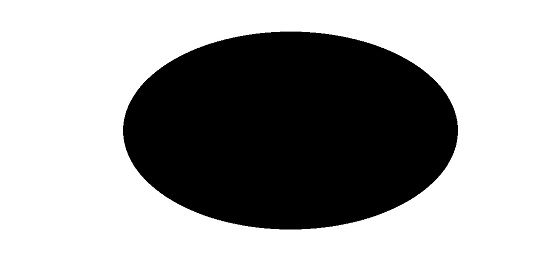

In [104]:
Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg") # 부정리뷰 워드클라우드에서는 원하는 이미지로 대체할 것

In [105]:
import numpy as np
mask_array = np.array(Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg"))
mask_array

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

옵션정리

alicewc = WordCloud(
    
    background_color = "white",# 배경색 설정

    collocations = False, # 이때 collocations=True 이면 said King, said Hatter 같이 자주 나타나는 단어는 하나의 어구로 분류됨.

    stopwords = stopwords, #불용어 지정

    width = 600, height = 400, #이미지 크기 지정

    colormap = "Reds", # 글씨 색깔 지정

    #font_path = 'path입력'

    min_font_size = 5, max_font_size = 100 #폰트 지정 작게할수록 더 많은 글씨가 보이고 크게하면 글자가 강조됨. 
    
    )

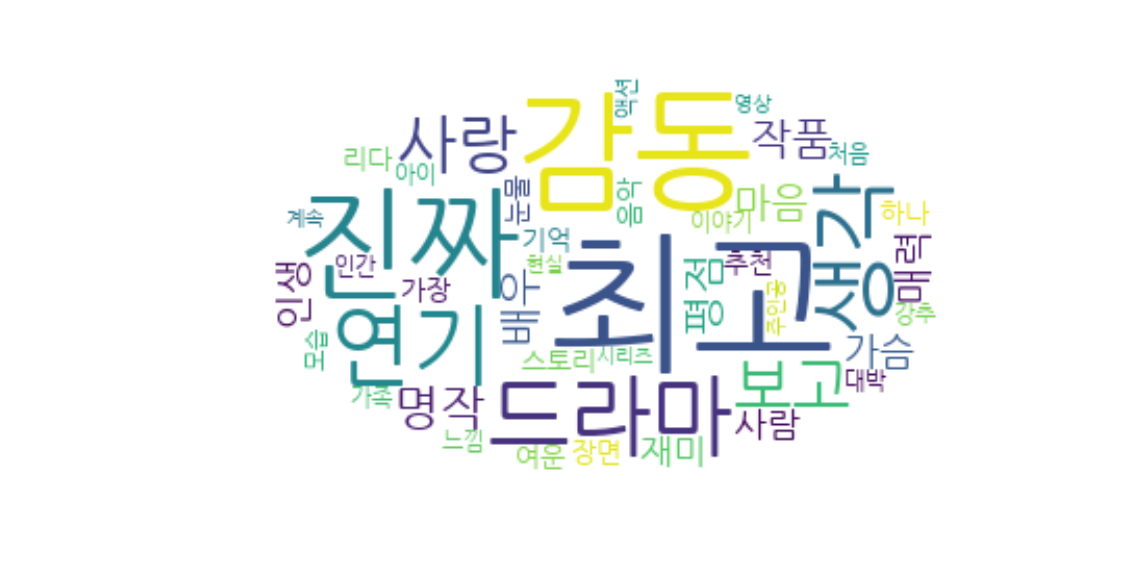

In [107]:
mask1 = np.array(Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg"))

wordcloud = WordCloud(
    font_path = fontpath, 
    width = 800,
    height = 800,
    background_color="white",
    mask = mask1
)

wordcloud = wordcloud.generate_from_frequencies(posword3)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## # To do 부정리뷰 워드클라우드

부정리뷰 워드클라우드를 생성해주세요!

In [109]:
content_list = list(neg['main_pos'])
noun_list = []

for sentence in content_list:


    sentence = re.sub('[a-zA-z0-9]','', sentence)
    
    for word, tag in okt.pos(sentence):
      # 명사만 추출
        if tag in ['Noun']:  

            if len(word) == 1:
                continue

            else:
                noun_list.append(word)

count = Counter(noun_list)
poswords = dict(count.most_common(n=50)) 

In [110]:
poswords

{'감독': 83,
 '개봉': 24,
 '결말': 29,
 '공포': 27,
 '그냥': 80,
 '내용': 93,
 '느낌': 29,
 '드라마': 36,
 '무슨': 31,
 '뭔가': 29,
 '배우': 77,
 '별로': 66,
 '보고': 47,
 '보지': 27,
 '사람': 54,
 '생각': 46,
 '소재': 32,
 '수준': 37,
 '스토리': 111,
 '시간': 103,
 '실망': 37,
 '쓰레기': 77,
 '알다': 59,
 '액션': 59,
 '연기': 61,
 '연출': 41,
 '영화': 770,
 '완전': 29,
 '웃기': 29,
 '원작': 28,
 '이건': 70,
 '이야기': 41,
 '이해': 35,
 '작품': 27,
 '재미': 99,
 '전개': 30,
 '전혀': 26,
 '점도': 31,
 '정도': 49,
 '정말': 91,
 '제목': 22,
 '졸작': 24,
 '주인공': 28,
 '진짜': 130,
 '처음': 45,
 '최악': 84,
 '캐릭터': 23,
 '코미디': 31,
 '평점': 125,
 '하나': 36}

In [113]:
# 불용어 제거
stop_words = ['진짜', '정말', '개봉', '결말', '드라마', '보고', '보지', '사람', '생각', '시간', '영화']
posword2 = [(i, j) for i, j in poswords.items() if i not in stop_words]

# 결과 출력
posword3 = dict(posword2)
print(posword3)

{'평점': 125, '스토리': 111, '재미': 99, '내용': 93, '최악': 84, '감독': 83, '그냥': 80, '쓰레기': 77, '배우': 77, '이건': 70, '별로': 66, '연기': 61, '액션': 59, '알다': 59, '정도': 49, '처음': 45, '연출': 41, '이야기': 41, '실망': 37, '수준': 37, '하나': 36, '이해': 35, '소재': 32, '무슨': 31, '점도': 31, '코미디': 31, '전개': 30, '완전': 29, '느낌': 29, '뭔가': 29, '웃기': 29, '주인공': 28, '원작': 28, '공포': 27, '작품': 27, '전혀': 26, '졸작': 24, '캐릭터': 23, '제목': 22}


In [114]:
from PIL import Image, ImageFilter

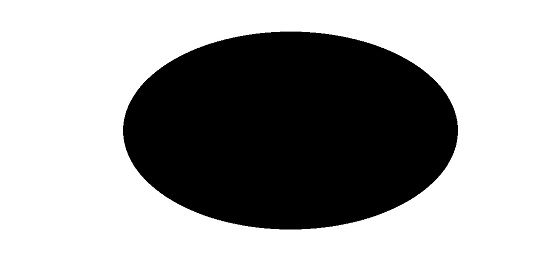

In [115]:
Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg") 

In [116]:
mask_array = np.array(Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg"))
mask_array

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

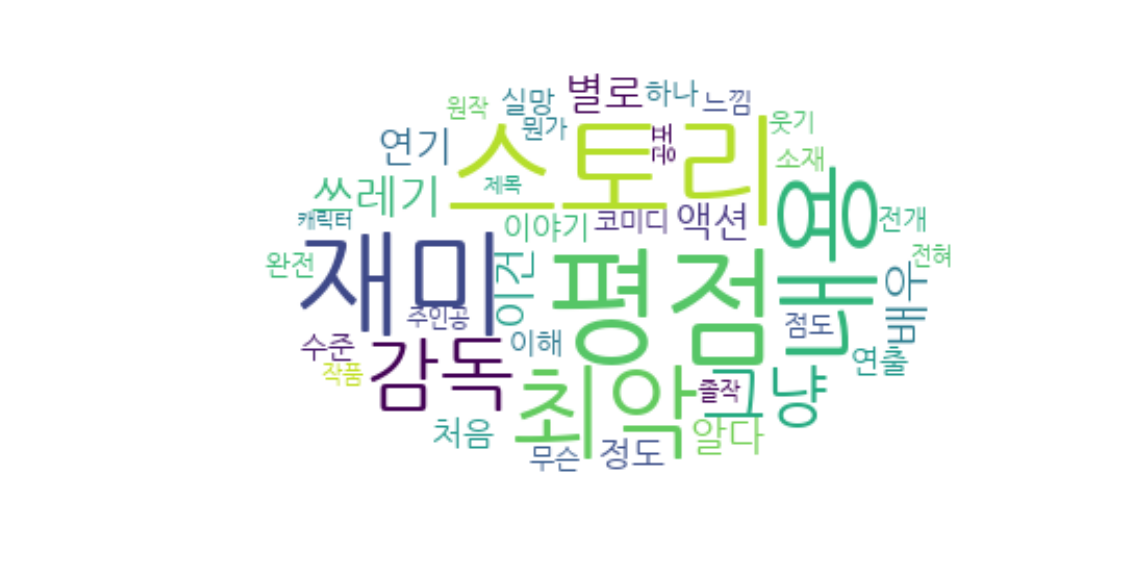

In [117]:
mask1 = np.array(Image.open("/content/drive/MyDrive/Ybigta_summer/KoNLPy/제목 없음.jpg"))

wordcloud = WordCloud(
    font_path = fontpath, 
    width = 800,
    height = 800,
    background_color="white",
    mask = mask1
)

wordcloud = wordcloud.generate_from_frequencies(posword3)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()